In [1]:
# data_cleaning.ipynb (or extend your EDA.ipynb)
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# Import the cleaning and correlation functions
from src.data_preprocessing import (
    remove_outliers_below_threshold,
    resample_data,
    compute_correlations,
    get_top_correlations,
    fill_nans_with_previous_day,
    fill_nans_day_before_after_interpolate,
    find_gaps_in_column,
    detect_and_plot_gaps,
    verify_no_internal_gaps
)

In [2]:
# ========== 1. Load Data (if not already loaded) ==========
file_path = '../data/raw/LD2011_2014.txt'
df = pd.read_csv(
    file_path, 
    sep=';', 
    decimal=',', 
    index_col=0, 
    parse_dates=True
)

In [3]:
# ========== 2. Remove Outliers Below Threshold ==========
threshold = 1.0  # Example: anything below 1 kWh is considered invalid/outlier
df_clean = remove_outliers_below_threshold(df, threshold=threshold)

# ========== 3. Resample to 30-Minute Intervals ==========
# The dataset is originally at 15-minute intervals, 
# but let's confirm or re-aggregate to 30-minute.
df_30min = resample_data(df_clean, freq='30min', agg='mean')

In [4]:
# ========== 4. Check Correlation Across All Meters ==========
# corr_matrix = compute_correlations(df_30min)
# top_correlations = get_top_correlations(corr_matrix, top_n=50)
# print("Top 50 Correlated Meter Pairs:\n", top_correlations)

In [5]:
# # ========== 5. Verify Cleaning with Random Meters ==========
# # Let's pick 5 random meter columns from df_30min
# all_meters = list(df_30min.columns)
# random_meters = random.sample(all_meters, 5)

# # Time-series plots for random meters
# df_30min[random_meters].plot(subplots=True, figsize=(12, 10), layout=(3,2), sharex=True)
# plt.suptitle("Time Series of 5 Random Meters (After Cleaning & 30-min Resample)")
# plt.tight_layout()
# plt.show()

# # Histograms for random meters
# import math

# rows = math.ceil(len(random_meters) / 2)
# fig, axes = plt.subplots(rows, 2, figsize=(12, 4*rows))
# axes = axes.flatten()

# for i, meter in enumerate(random_meters):
#     sns.histplot(df_30min[meter].dropna(), bins=50, kde=True, ax=axes[i])
#     axes[i].set_title(f"Distribution of {meter} (Cleaned)")
#     axes[i].set_xlabel("Consumption (kWh)")
#     axes[i].set_ylabel("Frequency")

# # Hide any extra subplots if random_meters < 10
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()

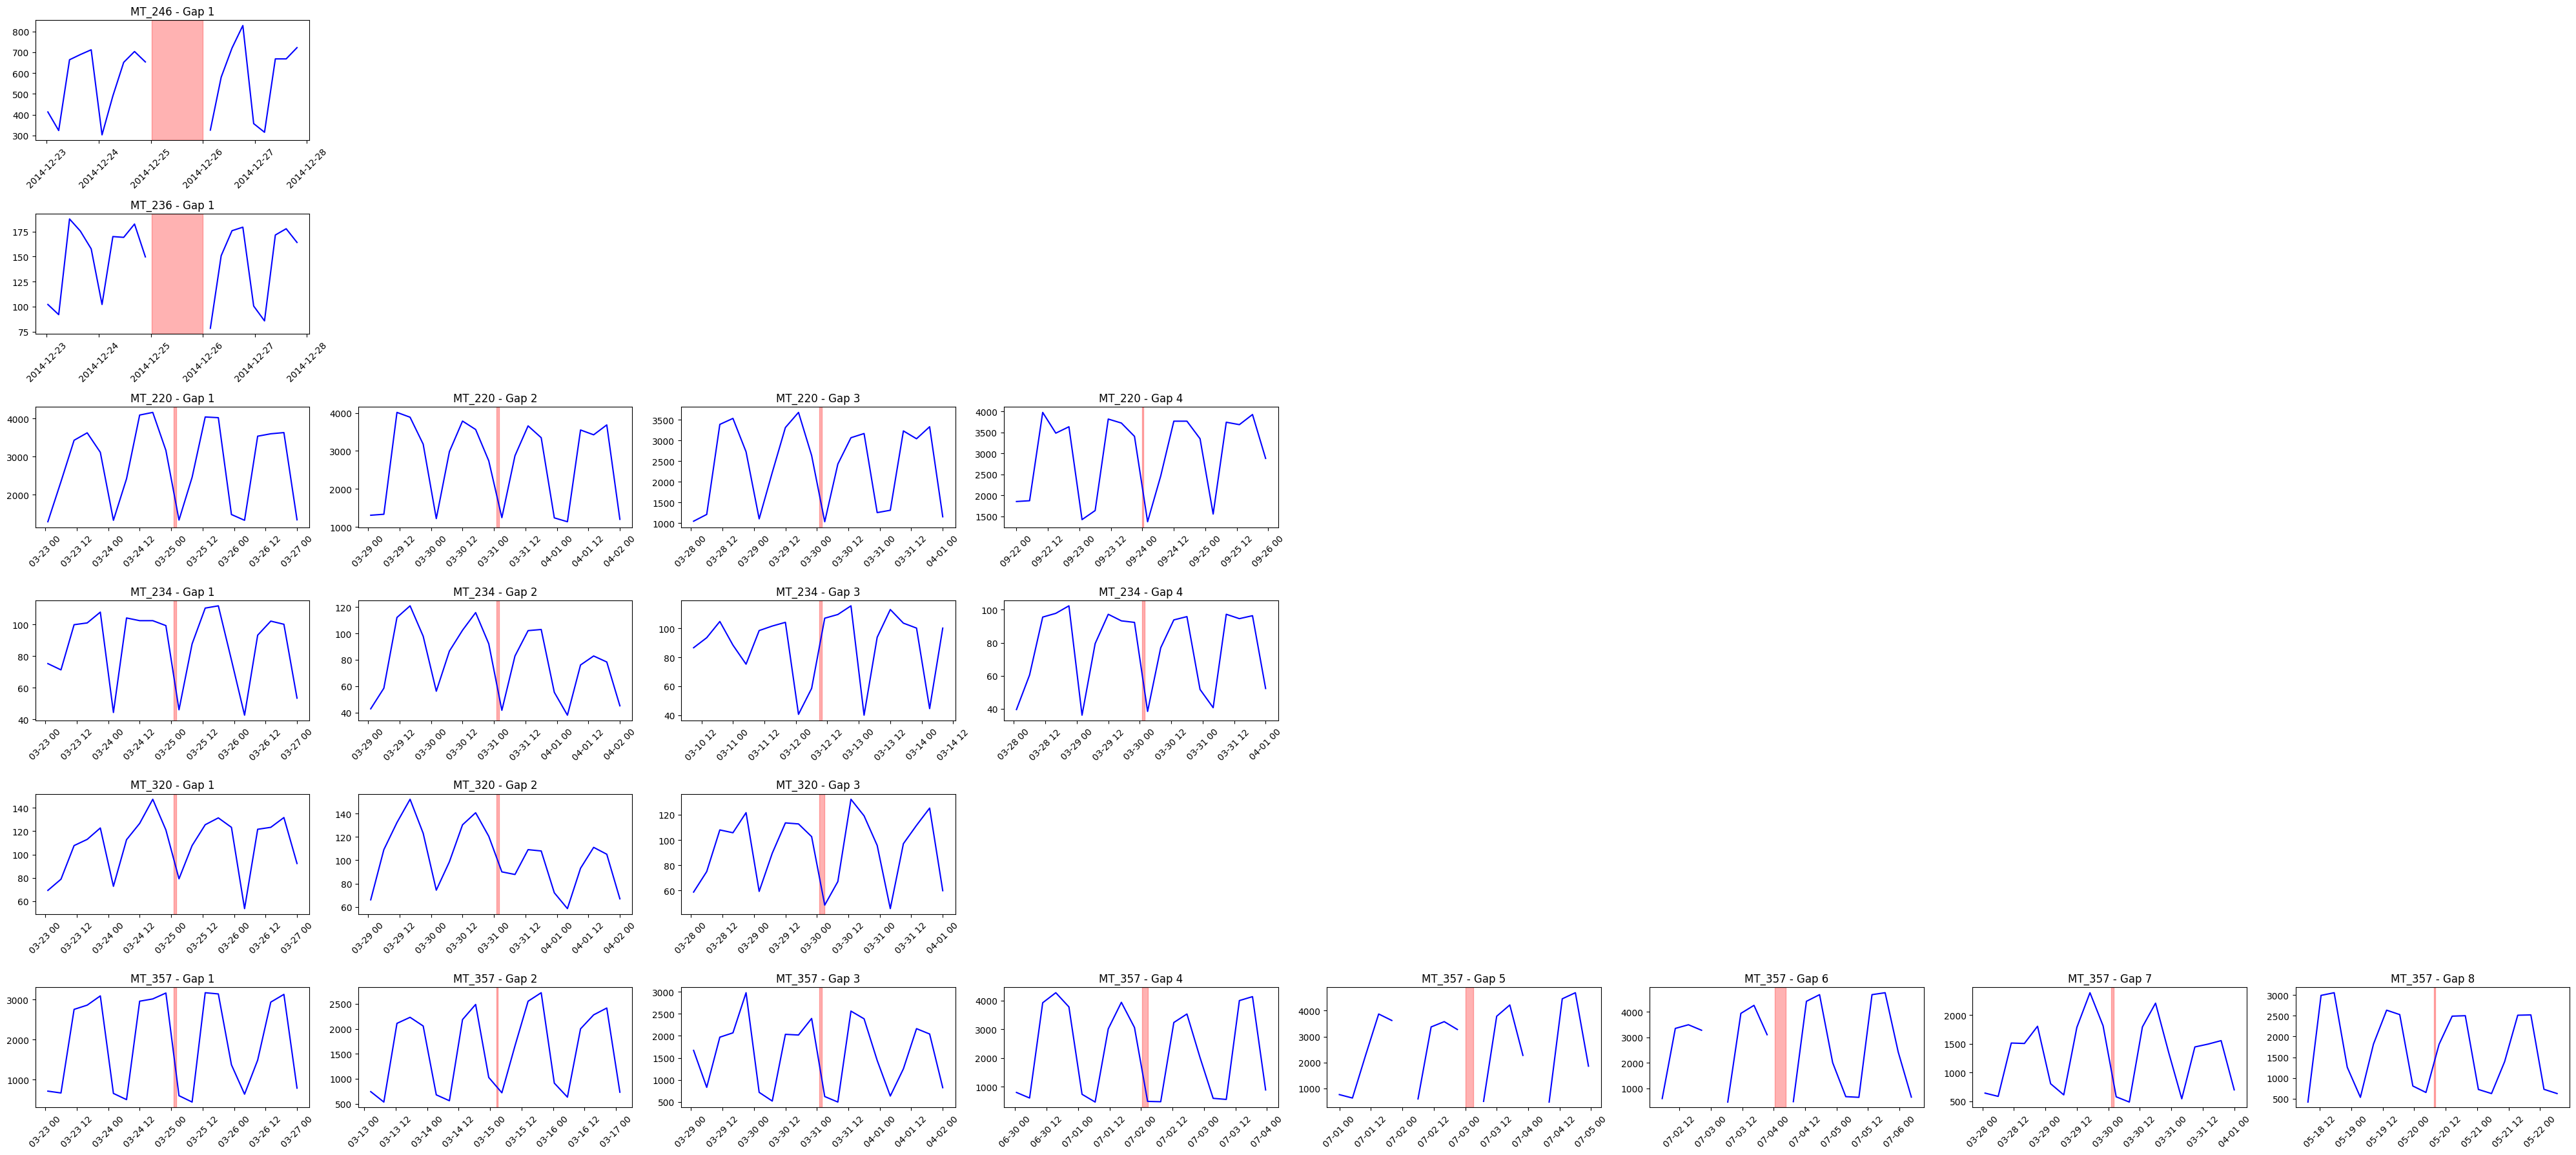

In [4]:
# Suppose 'df_30min' is your DataFrame after cleaning/resampling
detect_and_plot_gaps(df_30min, random_cols=6)

In [5]:
# ========== 1. Seasonal Fill ==========
df_temp = df_30min.copy()
for i in range(3):  # up to 3 passes
    new_filled = fill_nans_day_before_after_interpolate(df_30min, periods_per_day=48)
    # If no new NaNs were filled, we can break early
    if new_filled.equals(df_temp):
        break
    df_temp = new_filled
df_filled = df_temp

In [6]:
# Example usage:
verify_no_internal_gaps(df_filled)


No internal gaps detected for any client!


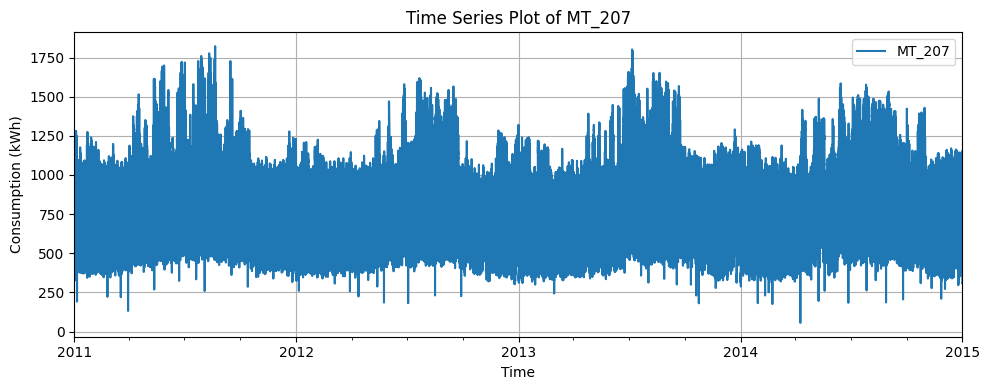

In [9]:
col = random.choice(df_filled.columns)
df_filled[col].plot(figsize=(10, 4))
plt.title(f"Time Series Plot of {col}")
plt.xlabel("Time")
plt.ylabel("Consumption (kWh)")


plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Save cleaned data as cleaned_data_30min.csv on C:\GithubRepo\network-traffic-anomaly-detection\data\processed
df_filled.to_csv('../data/processed/cleaned_data_30min.csv')
print("Data saved as cleaned_data_30min.csv")

Data saved as cleaned_data_30min.csv
